In [3]:
import numpy as np
import pyccl as ccl
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import scipy.interpolate as interpol
from pyccl._core import UnlockInstance
from scipy import signal

# Combined Profile for the Stellar, Ejected & Bound Gas components

## Stellar Profile

In [7]:
class StellarProfile(ccl.halos.profiles.profile_base.HaloProfile): 
    """Creating a class for the stellar density profile
    where: """  # could put in the equations used

    def __init__(self, mass_def):
        super(StellarProfile, self).__init__(mass_def=mass_def)

    def _real(self, r, M, centre_pt=None, scale_a=1): 
        r_use = np.atleast_1d(r) 
        M_use = np.atleast_1d(M)
        len_r = len(r_use) 
        
        prefix = M_use / scale_a**3
        prof = prefix[:, None] * signal.unit_impulse(len_r, centre_pt)[None,:]

        if np.ndim(r) == 0:
            prof = np.squeeze(prof, axis=-1)
        if np.ndim(M) == 0:
            prof = np.squeeze(prof, axis=0)
                                                          
        return prof

    def _fourier(self, k, M, scale_a=1):
        k_use = np.atleast_1d(k)
        M_use = np.atleast_1d(M)

        prefix = M_use / scale_a**3
        prof = np.ones_like(k_use)[None,:] * prefix[:, None] # k_use[None,:] + prefix[:, None] * 1 # as g(k) = 1

        if np.ndim(k) == 0:
            prof = np.squeeze(prof, axis=-1)
        if np.ndim(M) == 0:
            prof = np.squeeze(prof, axis=0)

        return prof
    

## Ejected Gas & Bound Gas Profiles (separate profiles)

In [10]:
class EjectedGasProfile(ccl.halos.profiles.profile_base.HaloProfile): #(ccl.halos.Haloprofile):
    """Creating a class for the ejected gas density profile
    where: """  # could put in the equations used

    def __init__(self, cosmo, mass_def): 
        super(EjectedGasProfile, self).__init__(mass_def=mass_def)
        self.cosmo = cosmo

    def _real(self, r, M, delta=200, eta_b = 0.5, scale_a=1): 
        r_use = np.atleast_1d(r) # need them to be functional arrays
        M_use = np.atleast_1d(M)
        r_vir = self.mass_def.get_radius(self.cosmo, M_use, scale_a) / scale_a # halo virial radius
        r_e = 0.375*r_vir*np.sqrt(delta)*eta_b # eta_b = a free parameter

        prefix = M_use * (1/(scale_a*np.sqrt(2*np.pi*r_e)))**3
        x = r_use[None, :] / r_e[:, None]
        prof = prefix[:, None] * np.exp(-(x**2)/2)

        if np.ndim(r) == 0:
            prof = np.squeeze(prof, axis=-1)
        if np.ndim(M) == 0:
            prof = np.squeeze(prof, axis=0)
                                                          
        return prof

    def _fourier(self, k, M, delta=200, eta_b = 0.5, scale_a=1):
        k_use = np.atleast_1d(k)
        M_use = np.atleast_1d(M)
        r_vir = self.mass_def.get_radius(self.cosmo, M_use, scale_a) / scale_a # halo virial radius
        r_e = 0.375*r_vir*np.sqrt(delta)*eta_b # eta_b = a free parameter

        prefix = M_use / scale_a**3
        x = k_use[None, :] * r_e[:, None]
        prof = prefix[:, None] * np.exp(-(x**2)/2)  #prof = M_use * f * np.exp(-(1/2)*(k_use*r_ej)**2)/(a**3)

        if np.ndim(k) == 0:
            prof = np.squeeze(prof, axis=-1)
        if np.ndim(M) == 0:
            prof = np.squeeze(prof, axis=0)

        return prof
    

In [12]:
class BoundGasProfile(ccl.halos.profiles.profile_base.HaloProfile): #(ccl.halos.Haloprofile):
    """Creating a class for the bound gas density profile
    where: """  # could put in the equations used

    def __init__(self, cosmo, mass_def, concentration, gamma, GammaRange = (1.01, 10), nGamma=64, qrange=(1e-4, 1e2), nq=64): 
        # n_q/Gamma = 2^x
        self.gamma = gamma
        super(BoundGasProfile, self).__init__(mass_def=mass_def, concentration=concentration)
        self.cosmo = cosmo

        self.GammaRange = GammaRange
        self.nGamma = nGamma

        self.qrange = qrange
        self.nq = nq
        
        self._func_normQ0 = None   # General normalised profile (for q=0, over Gamma)
        self._func_normQany = None

    def _shape(self, x, gam):
        gam_use = np.atleast_1d(gam)
        return (np.log(1+x)/x)**gam_use

    def _innerInt(self, x, gam): 
        return x**2 * self._shape(x, gam)   

    import scipy.integrate as integrate
    import scipy.interpolate as interpol
    from pyccl._core import UnlockInstance

    def _Vb_prefix(self, r_s=1):
        vB1 = integrate.quad(self._innerInt, 0, np.inf, args = (1/(self.gamma-1)))  # (func, a, b[, args, full_output, ...])
        vB2 = 4*np.pi*(r_s**3)*vB1[0]
        return vB2

    def _norm_interpol1(self):  # interpol1 = for q = 0
        gamma_list = np.linspace(self.GammaRange[0], self.GammaRange[1], self.nGamma) # start, stop, number of evenly spaced samples
        I0_array = np.zeros(self.nGamma)
        k=0
        for i in gamma_list:
            I0_array[k] =  integrate.quad(self._innerInt, 0, np.inf, args = 1/(i-1))[0] # _innerInt(self, x, gam=1/(gamma_use-1))
            k+=1
        func_normQ0 = interpol.interp1d(gamma_list, I0_array) # interp1d(x, y, ...
        return func_normQ0
        
    def _real(self, r, M, call_interp=True, scale_a=1): 
        r_use = np.atleast_1d(r) # need them to be functional arrays
        M_use = np.atleast_1d(M)
        
        R_M = self.mass_def.get_radius(self.cosmo, M_use, scale_a) / scale_a # halo virial radius
        c_M = self.concentration(self.cosmo, M_use, scale_a) # concentration-mass relation c(M)
        r_s = R_M / c_M # characteristic scale r_s

        if call_interp==False:
            vB_prefix = self._Vb_prefix(r_s)
        else:
            if self._func_normQ0 is None: # is instead of == here
                with UnlockInstance(self):
                    self._func_normQ0 = self._norm_interpol1() 
            vB_prefix = 4*np.pi*(r_s**3)*self._func_normQ0(self.gamma)  # self._Vb_prefix(gamma_use, rS_use)[0]
        prefix = M_use * (1/scale_a**3) * (1/vB_prefix)

        x = r_use[None, :] / r_s[:, None]
        prof = prefix[:, None] * self._shape(x, 1/(self.gamma-1)) # default par of gam = 1/(gamma_use-1) #innerInt(x)

        if np.ndim(r) == 0:
            prof = np.squeeze(prof, axis=-1)
        if np.ndim(M) == 0:
            prof = np.squeeze(prof, axis=0)
                                                          
        return prof

    def _norm_interpol2(self):  # interpol1 for q = any
        gamma_list = np.linspace(self.GammaRange[0], self.GammaRange[1], self.nGamma) # start, stop, number of evenly spaced samples
        q_array = np.geomspace(self.qrange[0], self.qrange[1], self.nq) # q = k*r_s, k will be from geomspace
        I0_array =  np.zeros((self.nGamma, self.nq))

        def integralQany(x, gam): #(a, gam=1/(gamma_use-1), b=1, c=1):
            return x * self._shape(x, gam) # for q = any (& j0(qx) = sinh(qx) = sin(qx)/(qx) => int[x^2 ... j0] = int[x ... sin(qx)]/q
        k=0
        for i in gamma_list: 
            l=0
            for j in q_array: 
                I0_array[k, l] =  integrate.quad(integralQany, 0, np.inf, args = 1/(i-1), weight = "sin", wvar=j)[0] / j
                l+=1
            k+=1
            print(f'k = {100*k/self.nGamma:.3g}% through')
        #interpol.RegularGridInterpolator() for 2D array # (points, values, ... 
        func_normQany = interpol.RegularGridInterpolator((gamma_list, np.log(q_array)), I0_array)
        return func_normQany
    
    def _fourier(self, k, M, scale_a=1):
        k_use = np.atleast_1d(k)
        M_use = np.atleast_1d(M)

        R_M = self.mass_def.get_radius(self.cosmo, M_use, scale_a) / scale_a # halo virial radius
        c_M = self.concentration(cosmo, M_use, scale_a) # concentration-mass relation c(M)
        r_s = R_M / c_M # characteristic scale r_s

        if self._func_normQ0 is None: # is instead of == here
            with UnlockInstance(self):
                self._func_normQ0 = self._norm_interpol1() 
        if self._func_normQany is None:
            with UnlockInstance(self):
                self._func_normQany = self._norm_interpol2()

        q_use = k_use[None, :]*r_s[:, None]
        g_k = self._func_normQany((self.gamma, np.log(q_use))) / self._func_normQ0(self.gamma) # = Ib_qAny / Ib_q0

        prefix = M_use / scale_a**3
        prof = prefix[:, None] * g_k[None,:] 

        if np.ndim(k) == 0:
            prof = np.squeeze(prof, axis=-1)
        if np.ndim(M) == 0:
            prof = np.squeeze(prof, axis=0)

        return prof
    

## Combined Gas Class

Add in equations: $\rho(r)\ = f_b\ \rho_{bound}(r)\ + (1 - f_b)\rho_{ejected}(r)\ $

In [16]:
class CombinedGasProfile(ccl.halos.profiles.profile_base.HaloProfile): #boundGas_profile, ejGas_profile): 
    #ccl.halos.profiles.profile_base.HaloProfile): 
    """Text
    """

    def __init__(self, cosmo, mass_def, concentration, gamma, GammaRange = (1.01, 10), nGamma=64, qrange=(1e-4, 1e2), nq=64):

        self.gamma = gamma
        super(CombinedGasProfile, self).__init__(mass_def=mass_def, concentration=concentration)
        self.boundProfile = BoundGasProfile(cosmo=cosmo, mass_def=mass_def, concentration=concentration, gamma=gamma)
        self.ejProfile = EjectedGasProfile(cosmo=cosmo, mass_def=mass_def)

        self.GammaRange = GammaRange
        self.nGamma = nGamma
        self.qrange = qrange
        self.nq = nq
        self._func_normQ0 = None   # General normalised bound profile (for q=0, over Gamma)
        self._func_normQany = None

    def _real(self, r, M, f_bd=1, call_interp=True, scale_a=1):
        f_ej = 1 - f_bd
        prof_ej = self.ejProfile._real(r, M, scale_a) # ejGas_profile._real(self, r, M, scale_a)
        prof_bd = self.boundProfile._real(r, M, call_interp, scale_a) # boundGas_profile._real(self, r, M, call_interp, scale_a)
        profile = f_ej*prof_ej + f_bd*prof_bd
        return profile

    def _fourier(self, k, M, f_bd = 1, call_interp=True, scale_a=1):
        f_ej = 1 - f_bd
        prof_ej = self.ejProfile._fourier(k, M, scale_a)
        prof_bd = self.boundProfile._fourier(k, M, scale_a)
        profile = f_ej*prof_ej + f_bd*prof_bd[0]
        return profile

## Combined Gas & Stellar Profile

In [20]:
class CombinedStellarGasProfile(ccl.halos.profiles.profile_base.HaloProfile): 
    """Text
    """

    def __init__(self, cosmo, mass_def, concentration, gamma, GammaRange = (1.01, 10), nGamma=64, qrange=(1e-4, 1e2), nq=64,
                beta=0.6, M_c = 10**(13.5), M_star = 10**(12.5), A_star = 0.03, sigma_star = 1.2):
        self.gamma = gamma
        super(CombinedStellarGasProfile, self).__init__(mass_def=mass_def, concentration=concentration)
        self.boundProfile = BoundGasProfile(cosmo=cosmo, mass_def=mass_def, concentration=concentration, gamma=gamma)
        self.ejProfile = EjectedGasProfile(cosmo=cosmo, mass_def=mass_def)
        self.stellProfile = StellarProfile(mass_def=mass_def)

        self.GammaRange = GammaRange
        self.nGamma = nGamma
        self.qrange = qrange
        self.nq = nq
        self._func_normQ0 = None   # General normalised bound profile (for q=0, over Gamma)
        self._func_normQany = None

        self.cosmo = cosmo
        self.beta = beta
        self.M_c = M_c
        self.M_star = M_star
        self.A_star = A_star
        self.sigma_star = sigma_star
        
        self.f_bar_b = self.cosmo['Omega_b']/self.cosmo['Omega_m']
     #   self.f_c = 1 - self.f_bar_b # assumption for stellar&gas profile = that f_CDM = 0, so that 
     #   f_ej + f_stell + f_bd = 1 (even though self.f_bar_b does not actually = 1)
        
    def _f_stell(self, M):
        f_stell = self.A_star * np.exp( (-1/2)* (np.log10(M / self.M_star) / self.sigma_star)**2 )
        return f_stell

    def _f_bd(self, M):     #$f_b(M)\ = \frac{\bar{f}_b - f_*(M)}{1 + (M_c/M)^{\beta}} $
        f_stell = self._f_stell(M)
        f_b = (self.f_bar_b - f_stell) / (1 + (self.M_c / M)**self.beta )
        return f_b, f_stell

    def _real(self, r, M, #calc_frac=True, f_bd=1, f_stell=0, 
              call_interp=True, scale_a=1, centre_pt=None):
        #if calc_frac==True:
         #   f_stell = self._f_stell(M)
        
        f_bd, f_stell = self._f_bd(M)
        f_ej = 1 - f_stell - f_bd  # assumption for stellar&gas profile = that f_CDM = 0, so no: # self.f_bar_b - f_stell - f_bd
        
        prof_ej = self.ejProfile._real(r, M, scale_a) # ejGas_profile._real(self, r, M, scale_a)
        prof_bd = self.boundProfile._real(r, M, call_interp, scale_a) # boundGas_profile._real(self, r, M, call_interp, scale_a)
        prof_stell = self.stellProfile._real(r, M, centre_pt, scale_a) # _real(self, r, M, centre_pt=None, scale_a=1): 

        if np.shape(M) == ():
            prof_array = f_ej*prof_ej + f_bd*prof_bd + f_stell*prof_stell
        else:
            prof_array = np.zeros(len(M), dtype=object)
            i = 0
            for e, b, s in zip(f_ej, f_bd, f_stell): # should be same as: for mass in M
                profile = e*prof_ej[i] + b*prof_bd[i] + s*prof_stell[i]
                prof_array[i] = profile
                i+=1
        return prof_array 

    def _fourier(self, k, M, # call_frac=True, f_bd = 1, f_stell=0, 
                 call_interp=True, scale_a=1, centre_pt=None):
        f_bd, f_stell = self._f_bd(M)
        f_ej = 1 - f_stell - f_bd  # assumption for stellar&gas profile = that f_CDM = 0, so no: # self.f_bar_b - f_stell - f_bd
        
        prof_ej = self.ejProfile._fourier(k, M, scale_a)
        prof_bd = self.boundProfile._fourier(k, M, scale_a)
        prof_stell = self.stellProfile._fourier(k, M, scale_a)  # _fourier(self, k, M, scale_a=1)

        if np.shape(M) == ():
            prof_array = f_ej*prof_ej + f_bd*prof_bd + f_stell*prof_stell
        else:
            prof_array = np.zeros(len(M), dtype=object)
            i = 0
     #       print(np.shape(prof_bd))
            for e, b, s in zip(f_ej, f_bd, f_stell): # should be same as: for mass in M
                profile = e*prof_ej[i] 
        #        print(np.shape(prof_bd[i]), np.shape(b), np.shape(prof_bd[0,i]))
                profile += b*prof_bd[0,i] 
                profile += s*prof_stell[i]
                prof_array[i] = profile
                i+=1
        return prof_array

Note: for eg- 3 masses, should have 3 fs (1 for each mass) & 3 profiles (1 for each mass), so should get 3 combined profiles in total

## Making the Fraction Equations

In [24]:
cosmo['Omega_b'] # can access values in cosmo object like this
cosmo['Omega_m']

NameError: name 'cosmo' is not defined

- $f_c\ + f_b\ +f_e\ + f_*\ = 1$
- Cold dark matter: $f_c\ = 1 - \bar{f}_b$      
    - where: $\bar{f}_b\ = f_b\ + f_e\ + f_*\ = \frac{\Omega_b}{\Omega_M}$
    - This is the same (?) as: $f_c\ = 1 - \frac{\Omega_b}{\Omega_M} = \frac{\Omega_c}{\Omega_m}$
- $f_*(M)\ = A_*\ \exp{\left[ -\frac{1}{2} \left( \frac{\log_{10}(M/M_*)}{\sigma_*} \right)^2 \right]}$     
    - with: $A_* = 0.03$, $M_* = 10^{12.5}M_{\odot} $, & $\sigma_* = 1.2$.            

- $f_b(M)\ = \frac{\bar{f}_b - f_*(M)}{1 + (M_c/M)^{\beta}} $      
    - with: $M_c \simeq 10^{13.5 - 14} M_{\odot}$ & $\beta \sim 0.6$
     
- $f_e(M)\ = \bar{f}_b\ - f_b(M)\ - f_*(M)\ $

## Trialing the CDM (truncated nfw) profile
- pyccl.halos.profiles.nfw.HaloProfileNFW(self, *, mass_def, concentration, fourier_analytic=True, projected_analytic=False, cumul2d_analytic=False, truncated=True)
    - mass_def (MassDef or str) – a mass definition object, or a name string.
    - concentration (Concentration) – concentration-mass relation to use with this profile.
    - fourier_analytic (bool) – set to True if you want to compute the Fourier profile analytically (& not through FFTLog).
    - projected_analytic (bool) – set to True if you want to compute the 2D projected profile analytically (& not through FFTLog).
    - cumul2d_analytic (bool) – set to True if you want to compute the 2D cumulative surface density analytically (& not through FFTLog).
    - truncated (bool) – set to True if the profile should be truncated at $r\ = r_{\Delta}\ $.
- _real(self, cosmo, r, M, a)
- if fourier_analytic:
    - self._fourier = self._fourier_analytic
- _fourier_analytic(self, cosmo, k, M, a)


In [62]:
test_NFWprofile = ccl.halos.profiles.nfw.HaloProfileNFW(mass_def = hmd_200c, concentration = cM, fourier_analytic=False) 

In [64]:
ccl.halos.profiles.nfw.HaloProfileNFW.fourier

<function pyccl.halos.profiles.profile_base.HaloProfile.fourier(self, cosmo, k, M, a)>

In [66]:
NFW_real = test_NFWprofile._real(cosmo, trial_r, trial_M, a=1)
NFW_fourierTrue = test_NFWprofile._fourier_analytic(cosmo, trial_k, trial_M, a=1)
NFW_fourierFalse = test_NFWprofile.fourier(cosmo, trial_k, trial_M, a=1)

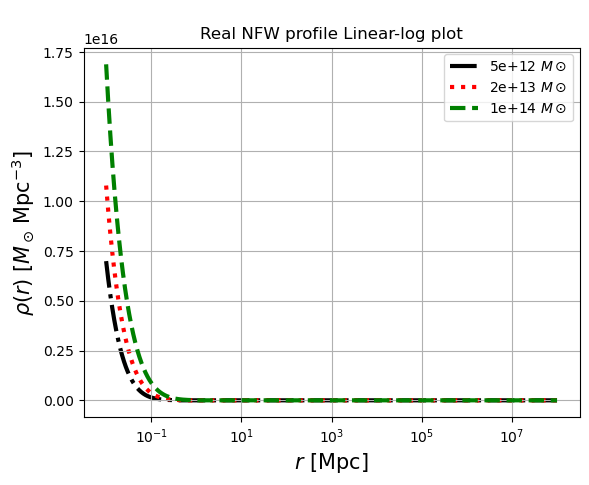

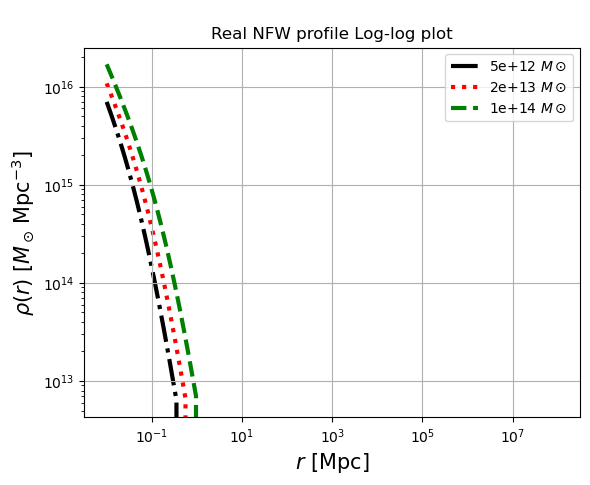

In [69]:
colours, i = ['k-.', 'r:', 'g--'], 0
title_real = '\nReal NFW profile' 
for j, col in zip(trial_M, colours):
    plt.plot(trial_r, NFW_real[i], col, lw=3, zorder = i, label=f'{trial_M[i]:.1g} $M \\odot $')
    i+=1
plt.ylabel(r'$\rho(r)\,\,[M_\odot\,{\rm Mpc}^{-3}]$', fontsize=15)
plt.xlabel(r'$r\,\,[{\rm Mpc}]$', fontsize=15);
plt.title(title_real+' Linear-log plot')
plt.grid(True)
plt.legend(loc='best')
plt.xscale('log');   #plt.xlim(1e-2,1e5);   #plt.ylim(1e-2,1e5);

plt.figure()
i = 0
for j, col in zip(trial_M, colours):
    plt.plot(trial_r, NFW_real[i], col, lw=3, zorder = i, label=f'{trial_M[i]:.1g} $M \\odot $')
    i+=1
plt.ylabel(r'$\rho(r)\,\,[M_\odot\,{\rm Mpc}^{-3}]$', fontsize=15)
plt.xlabel(r'$r\,\,[{\rm Mpc}]$', fontsize=15);
plt.title(title_real+' Log-log plot')
plt.grid(True)
plt.legend(loc='best')
plt.xscale('log');
plt.yscale('log');  

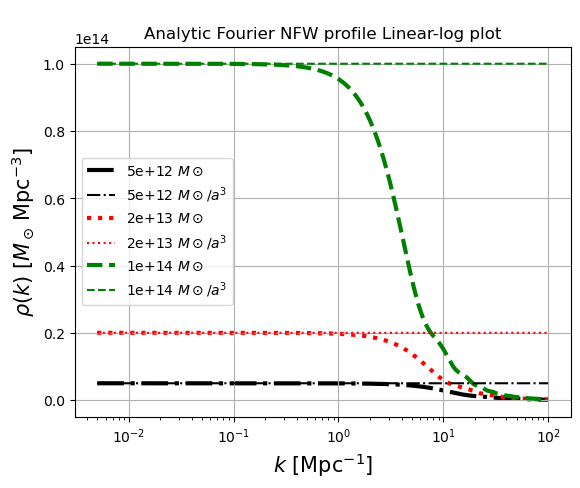

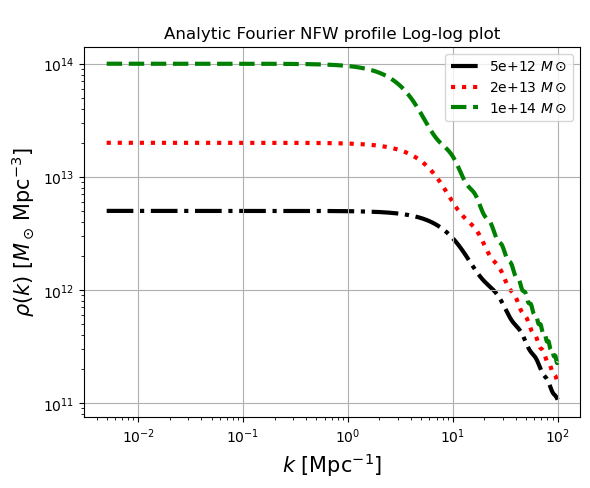

In [72]:
colours, i = ['k-.', 'r:', 'g--'], 0
title_fourier = '\nAnalytic Fourier NFW profile'
for mass, col, fourier in zip(trial_M, colours, NFW_fourierTrue):
    plt.plot(trial_k, fourier, col, lw=3, zorder = i, label=f'{mass:.1g} $M \\odot $')
    plt.plot(trial_k, 1*trial_k + mass, col, zorder=(10-i), label=f'{mass:.1g} $M \\odot /a^3$')  # here, a=1
    i+=1
plt.ylabel(r'$\rho(k)\, \,[M_\odot\,{\rm Mpc}^{-3}]$', fontsize=15)
plt.xlabel(r'$k\, \,[{\rm Mpc^{-1}}]$', fontsize=15);
plt.title(title_fourier+' Linear-log plot')
plt.grid(True)
plt.legend(loc='best')
plt.xscale('log');   #plt.xlim(1e-2,1e5);   #plt.ylim(1e-2,1e5);

plt.figure()
i = 0
for j, col in zip(trial_M, colours):
    plt.plot(trial_k, NFW_fourierTrue[i], col, lw=3, zorder = i, label=f'{trial_M[i]:.1g} $M \\odot $')
    i+=1
plt.ylabel(r'$\rho(k)\, \,[M_\odot\,{\rm Mpc}^{-3}]$', fontsize=15)
plt.xlabel(r'$k\, \,[{\rm Mpc^{-1}}]$', fontsize=15);
plt.title(title_fourier+' Log-log plot')
plt.grid(True)
plt.legend(loc='best')
plt.xscale('log');
plt.yscale('log'); 

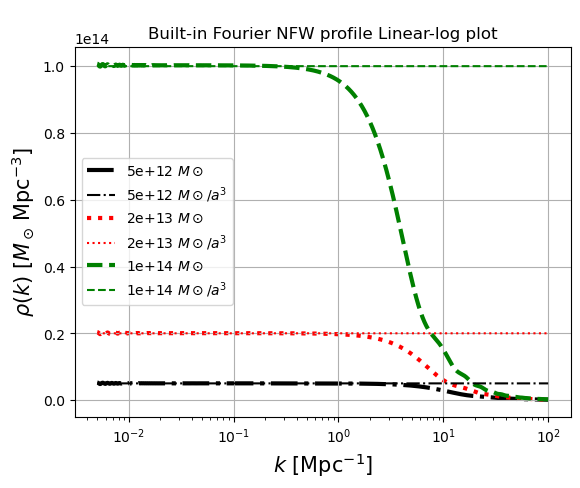

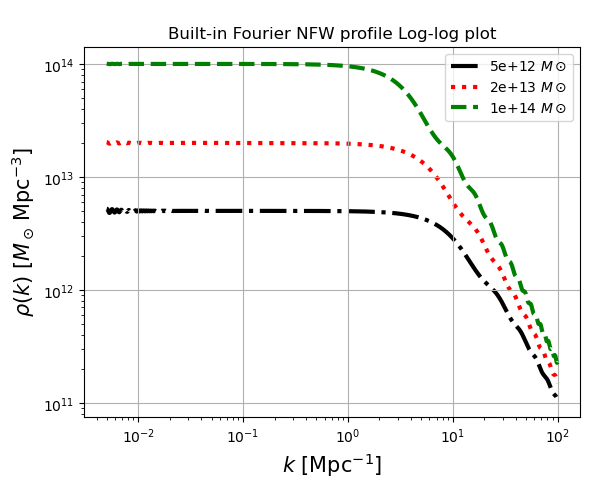

In [73]:
colours, i = ['k-.', 'r:', 'g--'], 0
title_fourier = '\nBuilt-in Fourier NFW profile'
for mass, col, fourier in zip(trial_M, colours, NFW_fourierFalse):
    plt.plot(trial_k, fourier, col, lw=3, zorder = i, label=f'{mass:.1g} $M \\odot $')
    plt.plot(trial_k, 1*trial_k + mass, col, zorder=(10-i), label=f'{mass:.1g} $M \\odot /a^3$')  # here, a=1
    i+=1
plt.ylabel(r'$\rho(k)\, \,[M_\odot\,{\rm Mpc}^{-3}]$', fontsize=15)
plt.xlabel(r'$k\, \,[{\rm Mpc^{-1}}]$', fontsize=15);
plt.title(title_fourier+' Linear-log plot')
plt.grid(True)
plt.legend(loc='best')
plt.xscale('log');   #plt.xlim(1e-2,1e5);   #plt.ylim(1e-2,1e5);

plt.figure()
i = 0
for j, col in zip(trial_M, colours):
    plt.plot(trial_k, NFW_fourierFalse[i], col, lw=3, zorder = i, label=f'{trial_M[i]:.1g} $M \\odot $')
    i+=1
plt.ylabel(r'$\rho(k)\, \,[M_\odot\,{\rm Mpc}^{-3}]$', fontsize=15)
plt.xlabel(r'$k\, \,[{\rm Mpc^{-1}}]$', fontsize=15);
plt.title(title_fourier+' Log-log plot')
plt.grid(True)
plt.legend(loc='best')
plt.xscale('log');
plt.yscale('log'); 

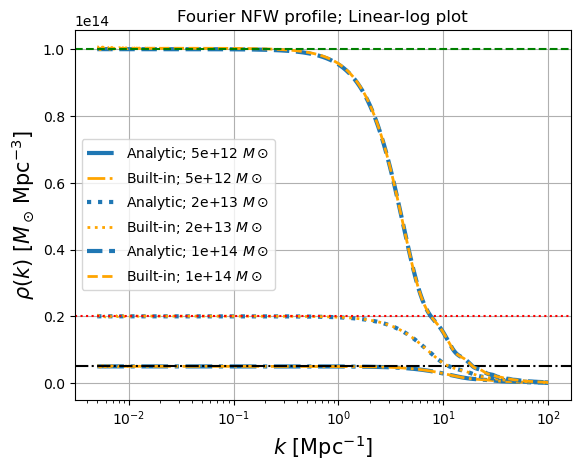

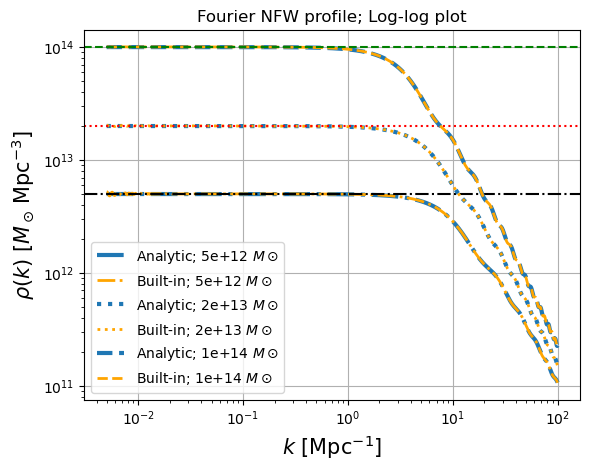

In [74]:
i = 0
for mass, col in zip(trial_M, colours):
    plt.plot(trial_k, NFW_fourierTrue[i], linestyle=col[1:], color='tab:blue', lw=3, label=f'Analytic; {mass:.1g} $M \\odot $')
    plt.plot(trial_k, NFW_fourierFalse[i], linestyle=col[1:], color='orange', lw=2, label=f'Built-in; {mass:.1g} $M \\odot $')
    plt.axhline(mass, color=col[0], linestyle=col[1:])
    i+=1
plt.ylabel(r'$\rho(k)\,\,[M_\odot\,{\rm Mpc}^{-3}]$', fontsize=15)
plt.xlabel(r'$k\,\,[{\rm Mpc^{-1}}]$', fontsize=15);
plt.title(f'Fourier NFW profile; Linear-log plot')
plt.grid(True)
plt.legend(loc='best')
plt.xscale('log');

plt.figure()
i = 0
for mass, col in zip(trial_M, colours):
    plt.plot(trial_k, NFW_fourierTrue[i], linestyle=col[1:], color='tab:blue', lw=3, label=f'Analytic; {mass:.1g} $M \\odot $')
    plt.plot(trial_k, NFW_fourierFalse[i], linestyle=col[1:], color='orange', lw=2, label=f'Built-in; {mass:.1g} $M \\odot $')
    plt.axhline(mass, color=col[0], linestyle=col[1:])
    i+=1
plt.ylabel(r'$\rho(k)\,\,[M_\odot\,{\rm Mpc}^{-3}]$', fontsize=15)
plt.xlabel(r'$k\,\,[{\rm Mpc^{-1}}]$', fontsize=15);
plt.title(f'Fourier NFW profile; Log-log plot')
plt.grid(True)
plt.legend(loc='best')
plt.xscale('log');
plt.yscale('log'); 

# Combined Stellar, Gas & CDM profile

In [42]:
class CombinedAllBCMProfile(ccl.halos.profiles.profile_base.HaloProfile): 
    """Text
    """

    def __init__(self, cosmo, mass_def, concentration, gamma, GammaRange = (1.01, 10), nGamma=64, qrange=(1e-4, 1e2), nq=64,
                beta=0.6, M_c = 10**(13.5), M_star = 10**(12.5), A_star = 0.03, sigma_star = 1.2):
        self.gamma = gamma
        super(CombinedAllBCMProfile, self).__init__(mass_def=mass_def, concentration=concentration)
        self.boundProfile = BoundGasProfile(cosmo=cosmo, mass_def=mass_def, concentration=concentration, gamma=gamma)
        self.ejProfile = EjectedGasProfile(cosmo=cosmo, mass_def=mass_def)
        self.stellProfile = StellarProfile(mass_def=mass_def)
        # add in nfw profile
        self.cdmProfile = ccl.halos.profiles.nfw.HaloProfileNFW(mass_def=mass_def, concentration=concentration)

        self.GammaRange = GammaRange
        self.nGamma = nGamma
        self.qrange = qrange
        self.nq = nq
        self._func_normQ0 = None   # General normalised bound profile (for q=0, over Gamma)
        self._func_normQany = None

        self.cosmo = cosmo
        self.beta = beta
        self.M_c = M_c
        self.M_star = M_star
        self.A_star = A_star
        self.sigma_star = sigma_star
        
        self.f_bar_b = self.cosmo['Omega_b']/self.cosmo['Omega_m']
        self.f_c = 1 - self.f_bar_b
        
    def _f_stell(self, M):
        f_stell = self.A_star * np.exp( (-1/2)* (np.log10(M / self.M_star) / self.sigma_star)**2 )
        return f_stell

    def _f_bd(self, M):     #$f_b(M)\ = \frac{\bar{f}_b - f_*(M)}{1 + (M_c/M)^{\beta}} $
        f_stell = self._f_stell(M)
        f_b = (self.f_bar_b - f_stell) / (1 + (self.M_c / M)**self.beta )
        return f_b, f_stell

    def _real(self, r, M, #calc_frac=True, f_bd=1, f_stell=0, 
              call_interp=True, scale_a=1, centre_pt=None):
        #if calc_frac==True:
         #   f_stell = self._f_stell(M)
        
        f_bd, f_stell = self._f_bd(M)
        f_ej = self.f_bar_b - f_stell - f_bd
        
        prof_ej = self.ejProfile._real(r, M, scale_a) # ejGas_profile._real(self, r, M, scale_a)
        prof_bd = self.boundProfile._real(r, M, call_interp, scale_a) # boundGas_profile._real(self, r, M, call_interp, scale_a)
        prof_stell = self.stellProfile._real(r, M, centre_pt, scale_a) # _real(self, r, M, centre_pt=None, scale_a=1): 
        # add in prof_cdm from nfw profile
        prof_cdm = self.cdmProfile._real(self.cosmo, r, M, scale_a) # _real(self, cosmo, r, M, a)

        if np.shape(M) == ():
            prof_array = f_ej*prof_ej + f_bd*prof_bd + f_stell*prof_stell # + self.f_c*prof_cdm 
        else:
            prof_array = np.zeros(len(M), dtype=object)
            i = 0
            for e, b, s in zip(f_ej, f_bd, f_stell): # should be same as: for mass in M
                profile = e*prof_ej[i] + b*prof_bd[i] + s*prof_stell[i] + self.f_c*prof_cdm[i] 
                prof_array[i] = profile
                i+=1
        return prof_array

    def _fourier(self, k, M, # call_frac=True, f_bd = 1, f_stell=0, 
                 call_interp=True, scale_a=1, centre_pt=None):
        f_bd, f_stell = self._f_bd(M)
        f_ej = self.f_bar_b - f_stell - f_bd
        
        prof_ej = self.ejProfile._fourier(k, M, scale_a)
        prof_bd = self.boundProfile._fourier(k, M, scale_a)
        prof_stell = self.stellProfile._fourier(k, M, scale_a)  # _fourier(self, k, M, scale_a=1)
        # add in prof_cdm from nfw profile
        prof_cdm = self.cdmProfile._fourier(self.cosmo, k, M, scale_a) # _fourier_analytic(self, cosmo, k, M, a)

        if np.shape(M) == ():
            prof_array = f_ej*prof_ej + f_bd*prof_bd + f_stell*prof_stell # + self.f_c*prof_cdm 
        else:
            prof_array = np.zeros(len(M), dtype=object)
            i = 0
            for e, b, s in zip(f_ej, f_bd, f_stell): # should be same as: for mass in M
                profile = e*prof_ej[i] 
                profile += b*prof_bd[0,i] 
                profile += s*prof_stell[i] + self.f_c*prof_cdm[i]
                prof_array[i] = profile
                i+=1
        return prof_array

# Trial

In [46]:
hmd_200c = ccl.halos.MassDef200c # use a mass definition with Delta = 200
cM = ccl.halos.ConcentrationDuffy08(mass_def=hmd_200c)
cosmo = ccl.Cosmology(Omega_c = 0.25, Omega_b=0.05, h=0.7, A_s=2.1e-9, n_s=0.96, Neff=0, Omega_g=0)
# change h=0.07 to h=0.7

trial_r = np.geomspace(1E-2,1E8,100000) # geomspace is like linspace, but evenly spaces on a logscale
trial_M = np.array([5E12,2E13, 1E14])
trial_gamma = 1.1  # working with z = 0 (today) ; therefore a = 1 [default]
#trial_rEj = 100
#trial_rS = 1       

In [48]:
trial_profile = CombinedStellarGasProfile(cosmo, hmd_200c, cM, trial_gamma) 

## Real

In [51]:
trial_f_bd = 0.45
trial_f_stell = 0.05
profTrial_real = trial_profile._real(trial_r, trial_M) #, trial_f_bd, trial_f_stell) 
# _real(self, r, M, #calc_frac=True, f_bd=1, f_stell=0, 
              #call_interp=True, scale_a=1, centre_pt=None):
profTrial_real

/var/folders/fj/p1qj16jj5pl9df1rgw6p12tc000vry/T/ipykernel_20322/3654199575.py:41: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  I0_array[k] =  integrate.quad(self._innerInt, 0, np.inf, args = 1/(i-1))[0] # _innerInt(self, x, gam=1/(gamma_use-1))
/var/folders/fj/p1qj16jj5pl9df1rgw6p12tc000vry/T/ipykernel_20322/3654199575.py:41: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  I0_array[k] =  integrate.quad(self._innerInt, 0, np.inf, args = 1/(i-1))[0] # _innerInt(self, x, gam=1/(gamma_use-1))


array([array([1.04577805e+14, 1.04416017e+14, 1.04402180e+14, ...,
              4.21457801e-65, 4.20534230e-65, 4.19612682e-65])    ,
       array([1.85736250e+14, 1.85241938e+14, 1.85227792e+14, ...,
              1.32565652e-62, 1.32275556e-62, 1.31986094e-62])    ,
       array([2.79001892e+14, 2.77618320e+14, 2.77608247e+14, ...,
              8.66538122e-60, 8.64645124e-60, 8.62756260e-60])    ],
      dtype=object)

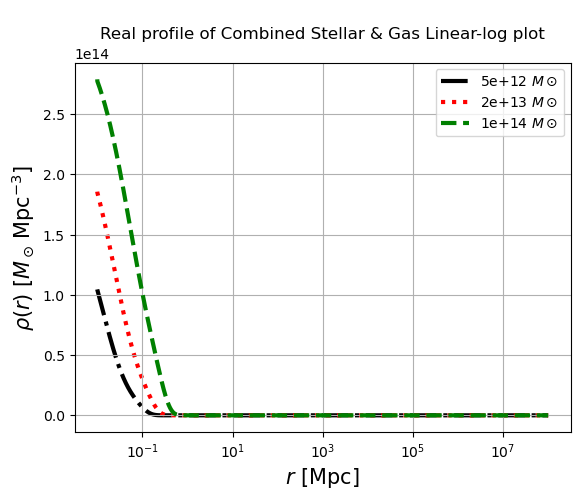

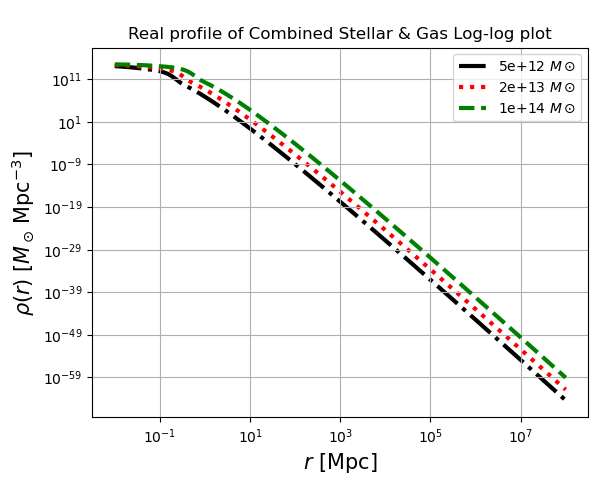

In [53]:
colours, i = ['k-.', 'r:', 'g--'], 0
title_real = '\nReal profile of Combined Stellar & Gas' #$f_{bd}=$'+f'{trial_f_bd*100}%'+' & $f_*=$'+f'{trial_f_stell*100}%; ' 
for j, col in zip(trial_M, colours):
    plt.plot(trial_r, profTrial_real[i], col, lw=3, zorder = i, label=f'{trial_M[i]:.1g} $M \\odot $')
    i+=1
plt.ylabel(r'$\rho(r)\,\,[M_\odot\,{\rm Mpc}^{-3}]$', fontsize=15)
plt.xlabel(r'$r\,\,[{\rm Mpc}]$', fontsize=15);
plt.title(title_real+' Linear-log plot')
plt.grid(True)
plt.legend(loc='best')
plt.xscale('log');   #plt.xlim(1e-2,1e5);   #plt.ylim(1e-2,1e5);

plt.figure()
i = 0
for j, col in zip(trial_M, colours):
    plt.plot(trial_r, profTrial_real[i], col, lw=3, zorder = i, label=f'{trial_M[i]:.1g} $M \\odot $')
    i+=1
plt.ylabel(r'$\rho(r)\,\,[M_\odot\,{\rm Mpc}^{-3}]$', fontsize=15)
plt.xlabel(r'$r\,\,[{\rm Mpc}]$', fontsize=15);
plt.title(title_real+' Log-log plot')
plt.grid(True)
plt.legend(loc='best')
plt.xscale('log');
plt.yscale('log');  

## Fourier

In [57]:
trial_k = np.geomspace(5E-3,1E2,100_000) # np.geomspace(1E-3,1E2,100000)
profTrial_fourier = trial_profile._fourier(trial_k, trial_M) #, trial_f_bd, trial_f_stell)
profTrial_fourier  #_fourier(self, k, M, # call_frac=True, f_bd = 1, f_stell=0, 
                # call_interp=True, scale_a=1, centre_pt=None)

/var/folders/fj/p1qj16jj5pl9df1rgw6p12tc000vry/T/ipykernel_20322/3654199575.py:22: RuntimeWarning: invalid value encountered in scalar divide
  return (np.log(1+x)/x)**gam_use
/var/folders/fj/p1qj16jj5pl9df1rgw6p12tc000vry/T/ipykernel_20322/3654199575.py:84: IntegrationWarning: The maximum number of cycles allowed has been achieved., e.e.
  of subintervals (a+(k-1)c, a+kc) where c = (2*int(abs(omega)+1))
  *pi/abs(omega), for k = 1, 2, ..., lst.  One can allow more cycles by increasing the value of limlst.  Look at info['ierlst'] with full_output=1.
  I0_array[k, l] =  integrate.quad(integralQany, 0, np.inf, args = 1/(i-1), weight = "sin", wvar=j)[0] / j


k = 1.56% through


/var/folders/fj/p1qj16jj5pl9df1rgw6p12tc000vry/T/ipykernel_20322/3654199575.py:84: IntegrationWarning: Bad integrand behavior occurs within one or more of the cycles.
  Location and type of the difficulty involved can be determined from 
  the vector info['ierlist'] obtained with full_output=1.
  I0_array[k, l] =  integrate.quad(integralQany, 0, np.inf, args = 1/(i-1), weight = "sin", wvar=j)[0] / j


k = 3.12% through
k = 4.69% through
k = 6.25% through
k = 7.81% through
k = 9.38% through
k = 10.9% through
k = 12.5% through
k = 14.1% through
k = 15.6% through
k = 17.2% through
k = 18.8% through
k = 20.3% through
k = 21.9% through
k = 23.4% through
k = 25% through
k = 26.6% through


/var/folders/fj/p1qj16jj5pl9df1rgw6p12tc000vry/T/ipykernel_20322/3654199575.py:84: IntegrationWarning: The extrapolation table constructed for convergence acceleration
  of the series formed by the integral contributions over the cycles, 
  does not converge to within the requested accuracy.  Look at 
  info['ierlst'] with full_output=1.
  I0_array[k, l] =  integrate.quad(integralQany, 0, np.inf, args = 1/(i-1), weight = "sin", wvar=j)[0] / j


k = 28.1% through
k = 29.7% through
k = 31.2% through
k = 32.8% through
k = 34.4% through
k = 35.9% through
k = 37.5% through
k = 39.1% through
k = 40.6% through
k = 42.2% through
k = 43.8% through
k = 45.3% through
k = 46.9% through
k = 48.4% through
k = 50% through
k = 51.6% through
k = 53.1% through
k = 54.7% through
k = 56.2% through
k = 57.8% through
k = 59.4% through
k = 60.9% through
k = 62.5% through
k = 64.1% through
k = 65.6% through
k = 67.2% through
k = 68.8% through
k = 70.3% through
k = 71.9% through
k = 73.4% through
k = 75% through
k = 76.6% through
k = 78.1% through
k = 79.7% through
k = 81.2% through
k = 82.8% through
k = 84.4% through
k = 85.9% through
k = 87.5% through
k = 89.1% through
k = 90.6% through
k = 92.2% through
k = 93.8% through
k = 95.3% through
k = 96.9% through
k = 98.4% through
k = 100% through


/var/folders/fj/p1qj16jj5pl9df1rgw6p12tc000vry/T/ipykernel_20322/3654199575.py:108: RuntimeWarning: overflow encountered in divide
  g_k = self._func_normQany((self.gamma, np.log(q_use))) / self._func_normQ0(self.gamma) # = Ib_qAny / Ib_q0
/var/folders/fj/p1qj16jj5pl9df1rgw6p12tc000vry/T/ipykernel_20322/3654199575.py:111: RuntimeWarning: overflow encountered in multiply
  prof = prefix[:, None] * g_k[None,:]


array([array([4.99999517e+12, 4.99999517e+12, 4.99999517e+12, ...,
                         inf,            inf,            inf])    ,
       array([1.99999562e+13, 1.99999562e+13, 1.99999562e+13, ...,
                         inf,            inf,            inf])    ,
       array([9.99993445e+13, 9.99993444e+13, 9.99993443e+13, ...,
                         inf,            inf,            inf])    ],
      dtype=object)

#### Normalisation of profiles means that:   
$\rho(k \to 0)\ _x = \frac{M_x}{a^3} [f_x]$   
For the combined gas profile, $\rho(r)\_{cbd} = \rho(r)\_{ej} + \rho(r)\_{bd}$    
And: $\rho(k)\_{cbd} = \rho(k)\_{ej} + \rho(k)\_{bd}$   
So: $\rho(k \to 0)\_{cbd} = f_{ej}\ \frac{M_{ej}}{a^3} + f_{bd}\ \frac{M_{bd}}{a^3} = \ $ (as $f_{ej} + f_{bd} \equiv 1 here$) $ = \frac{M_{cbd}}{a^3}$
#### So plotting $y = x + \frac{M_x}{a^3} [f_x]$ should give an overlap with the [normalised] Fourier density profile's plateau

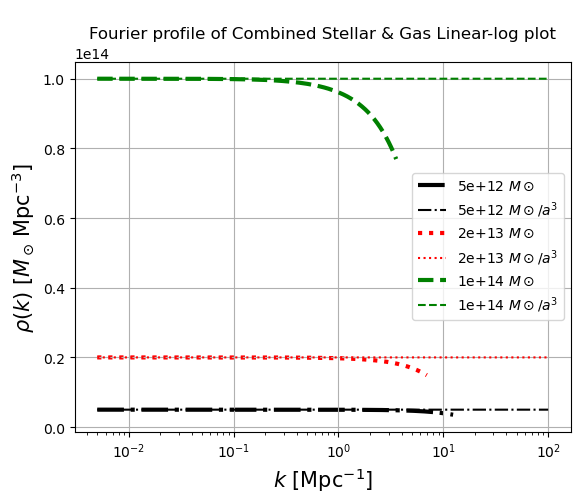

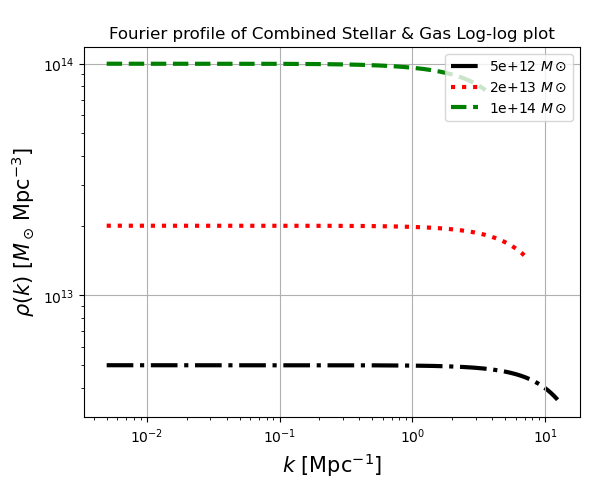

In [58]:
colours, i = ['k-.', 'r:', 'g--'], 0
title_fourier = '\nFourier profile of Combined Stellar & Gas'# $f_{bd}=$'+f'{trial_f_bd*100}%'+' & $f_*=$'+f'{trial_f_stell*100}%; ' 
for mass, col, fourier in zip(trial_M, colours, profTrial_fourier):
    plt.plot(trial_k, fourier, col, lw=3, zorder = i, label=f'{mass:.1g} $M \\odot $')
    plt.plot(trial_k, 1*trial_k + mass, col, zorder=(10-i), label=f'{mass:.1g} $M \\odot /a^3$')  # here, a=1
    i+=1
plt.ylabel(r'$\rho(k)\, \,[M_\odot\,{\rm Mpc}^{-3}]$', fontsize=15)
plt.xlabel(r'$k\, \,[{\rm Mpc^{-1}}]$', fontsize=15);
plt.title(title_fourier+' Linear-log plot')
plt.grid(True)
plt.legend(loc='best')
plt.xscale('log');   #plt.xlim(1e-2,1e5);   #plt.ylim(1e-2,1e5);

plt.figure()
i = 0
for j, col in zip(trial_M, colours):
    plt.plot(trial_k, profTrial_fourier[i], col, lw=3, zorder = i, label=f'{trial_M[i]:.1g} $M \\odot $')
    i+=1
plt.ylabel(r'$\rho(k)\, \,[M_\odot\,{\rm Mpc}^{-3}]$', fontsize=15)
plt.xlabel(r'$k\, \,[{\rm Mpc^{-1}}]$', fontsize=15);
plt.title(title_fourier+' Log-log plot')
plt.grid(True)
plt.legend(loc='best')
plt.xscale('log');
plt.yscale('log'); 